## Visualizing the dataset
In this Notebook, I'm going to perform some visualizations to understand the trends in the dataset using some popular Libraries.

In [12]:
# importing required libraries-

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [13]:
# reading the csv file
df = pd.read_csv('/kaggle/input/e-commerce-cleaned-data/cleaned_data.csv')

# Preview the data
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [14]:
df.dropna(subset=['CustomerID'], inplace=True)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# Converting InvoiceDate into Datetime format -
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

#  Creating TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

### Sales Over Time

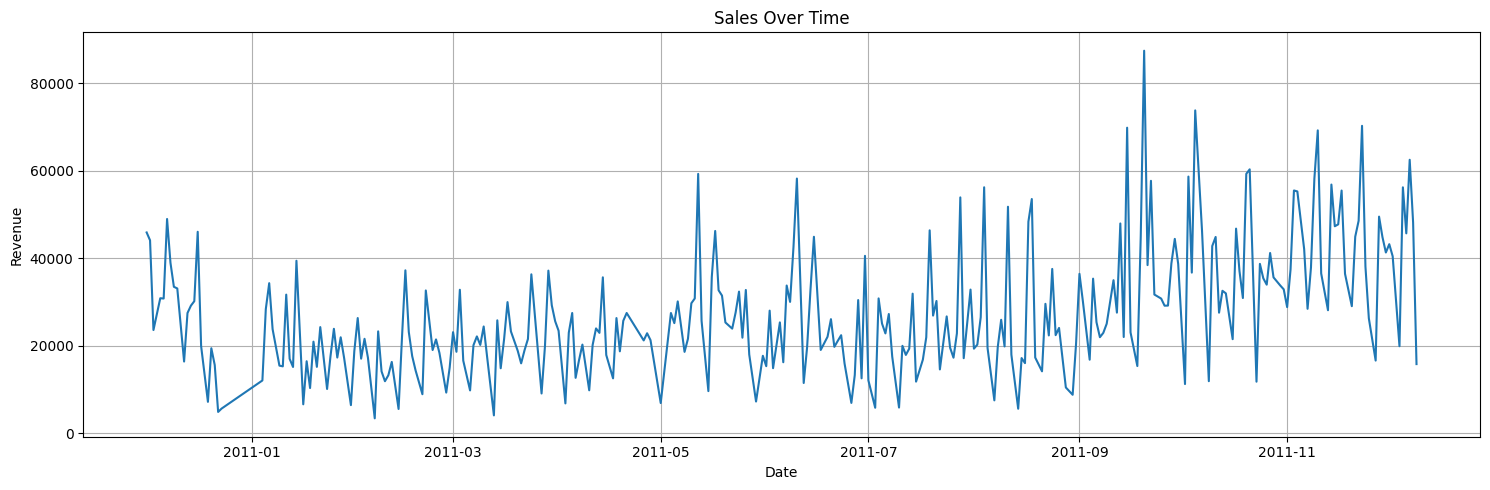

In [15]:
# Grouping data by date and summing up total sales for each day
sales_over_time = df.groupby(df['InvoiceDate'].dt.date)['TotalPrice'].sum()

# Creating the plot
plt.figure(figsize=(15,5))
sales_over_time.plot()

# Adding labels and title
plt.title("Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue")

# Adding grid and adjusting layout
plt.grid(True)
plt.tight_layout()
plt.show()

### Monthly Sales Trend (with seasonality insight)

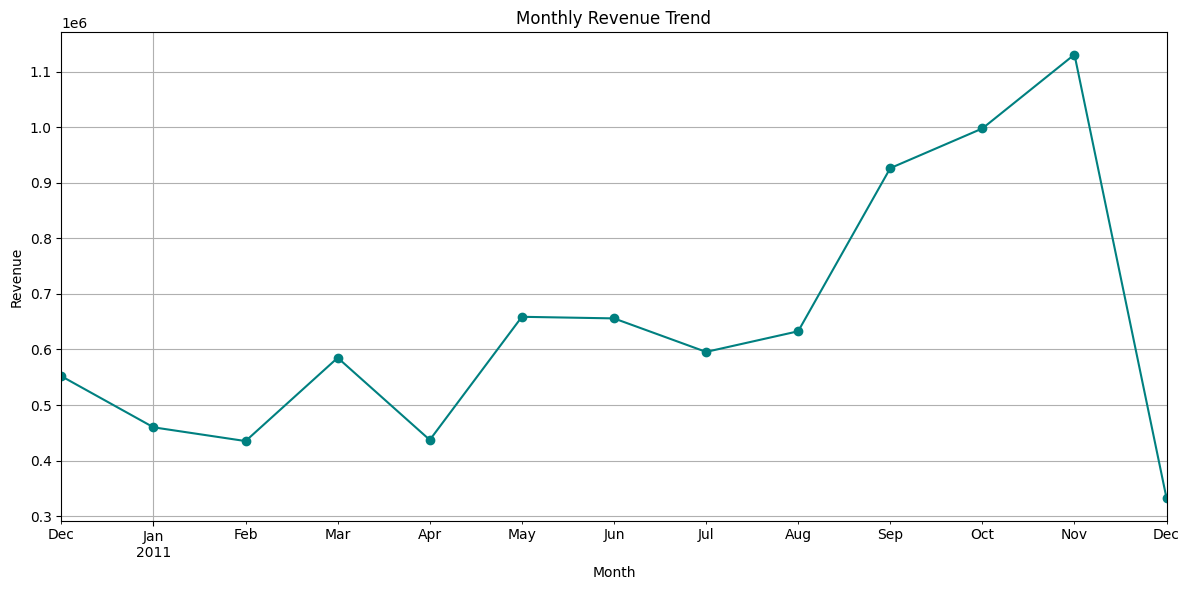

In [16]:
# Extract the month (year-month format) from InvoiceDate
df['Month'] = df['InvoiceDate'].dt.to_period('M')

# Group by month and sum up the revenue for each month
monthly_sales = df.groupby('Month')['TotalPrice'].sum()

# Plotting the monthly sales as a line chart
monthly_sales.plot(kind='line', figsize=(12,6), marker='o', color='teal')

# Adding title and axis labels
plt.title("Monthly Revenue Trend")
plt.ylabel("Revenue")
plt.xlabel("Month")

# Adding grid and layout tweaks
plt.grid(True)
plt.tight_layout()
plt.show()

### Sales by Day of Week

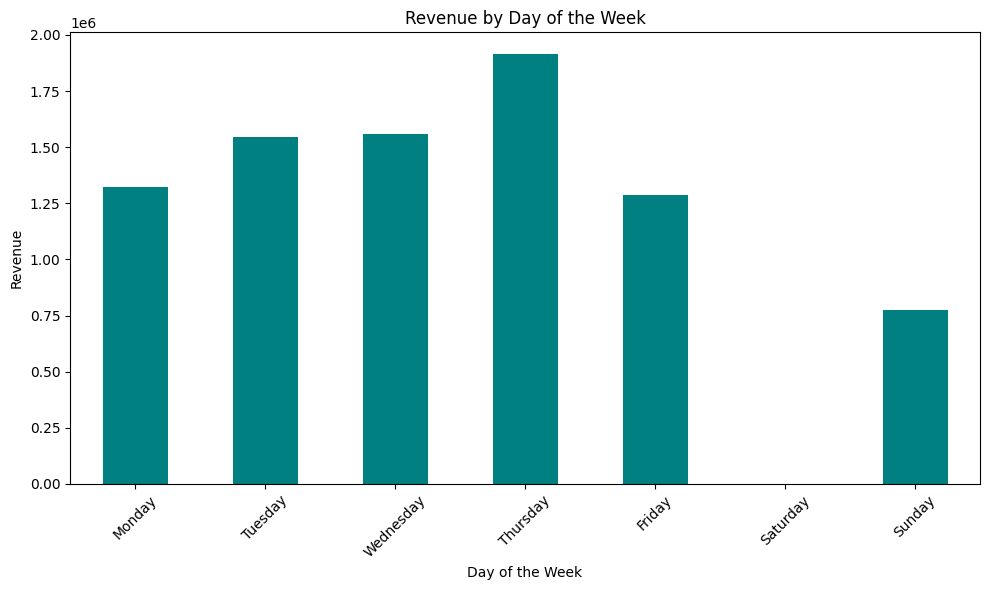

In [17]:
# Extract day name from InvoiceDate (e.g., Monday, Tuesday...)
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()

# Group by day of week and calculate total revenue for each day
# Reindexing to maintain logical weekday order
daywise_sales = df.groupby('DayOfWeek')['TotalPrice'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plotting as a bar chart
daywise_sales.plot(kind='bar', color='teal', figsize=(10,6))

# Adding title and labels
plt.title("Revenue by Day of the Week")
plt.ylabel("Revenue")
plt.xlabel("Day of the Week")

# Rotate x-axis labels and improve layout
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Country-wise Revenue Share (Pie Chart)

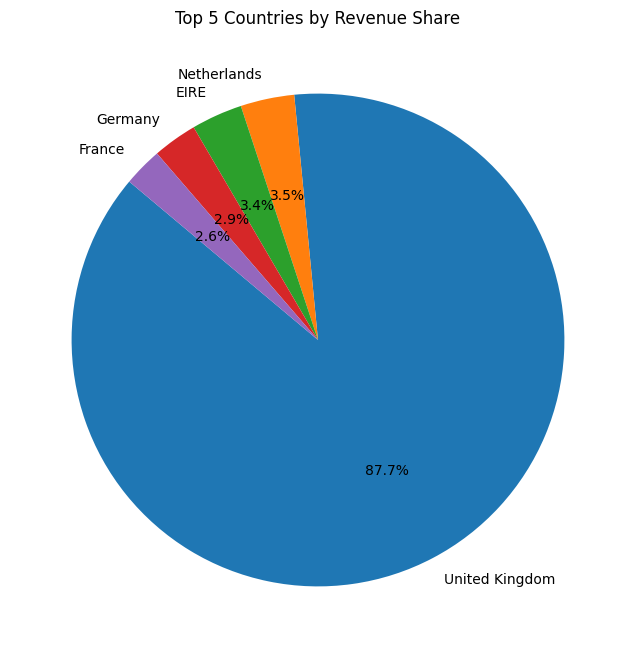

In [18]:
# Grouping by country and summing revenue, then selecting the top 5
top_countries = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(5)

# Plotting the pie chart
top_countries.plot(kind='pie', 
                   autopct='%1.1f%%',     # Show percentage values
                   figsize=(8,8), 
                   startangle=140,        # Rotate for better layout
                   legend=False)

# Adding a title and removing default y-axis label
plt.title("Top 5 Countries by Revenue Share")
plt.ylabel("")  # Hides the y-axis label for cleaner look
plt.show()

### Heatmap (Region vs Revenue)

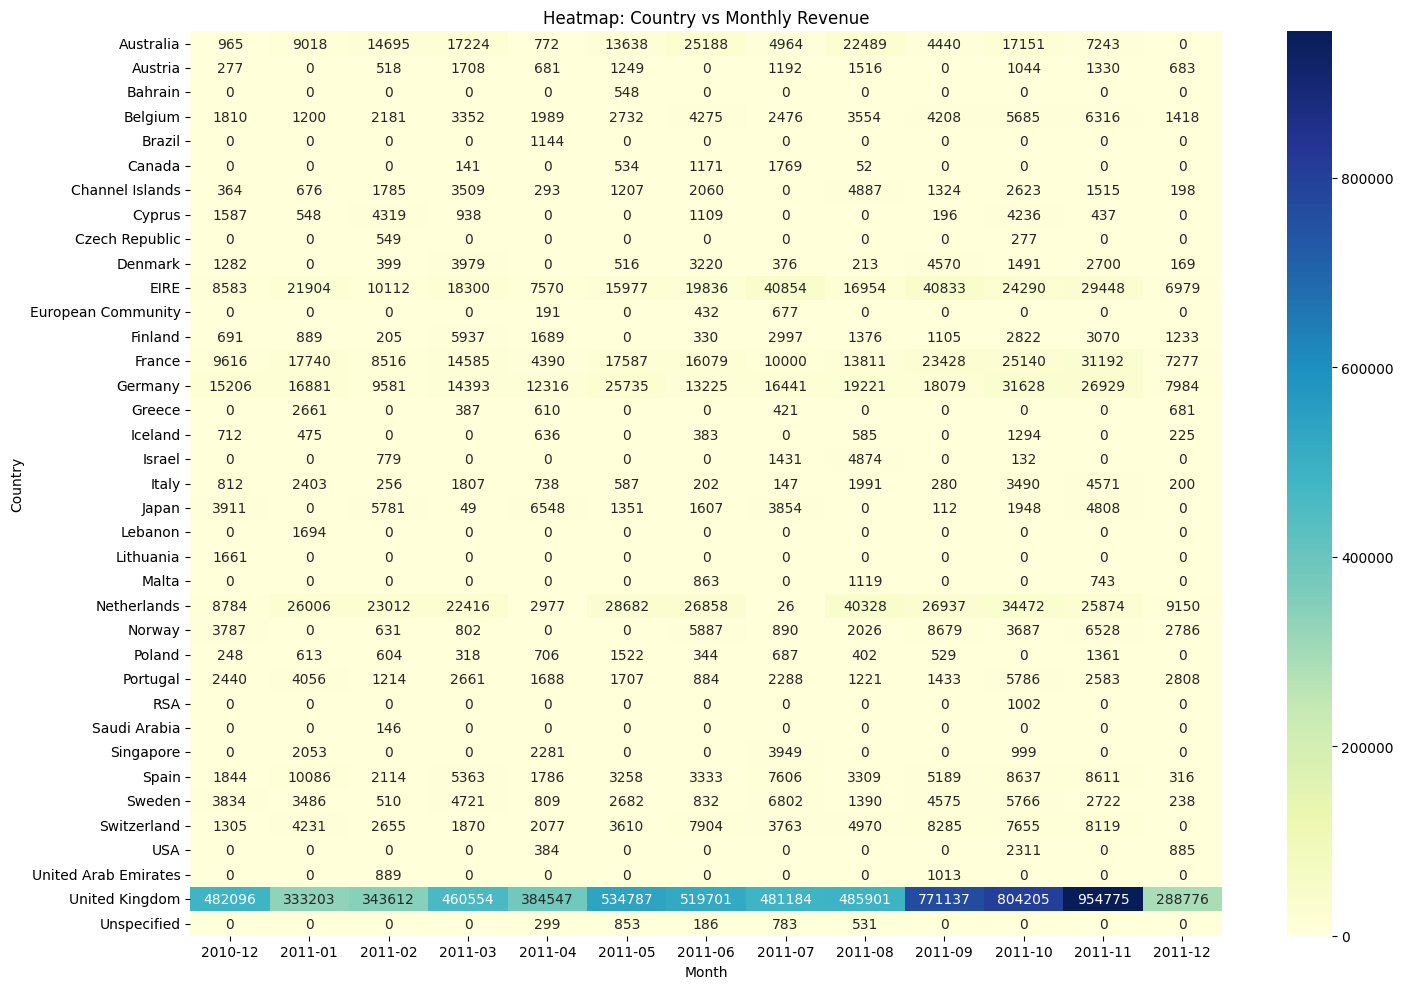

In [19]:
import seaborn as sns

#  Extract month from InvoiceDate
df['Month'] = df['InvoiceDate'].dt.to_period('M')

#  Prepare heatmap data: revenue per Country per Month
heatmap_data = df.groupby(['Country', 'Month'])['TotalPrice'].sum().unstack().fillna(0)

#  Plot the heatmap
plt.figure(figsize=(15,10))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='.0f')

#  Adding title and labels
plt.title("Heatmap: Country vs Monthly Revenue")
plt.xlabel("Month")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

### Bar Chart of Top-Selling Products

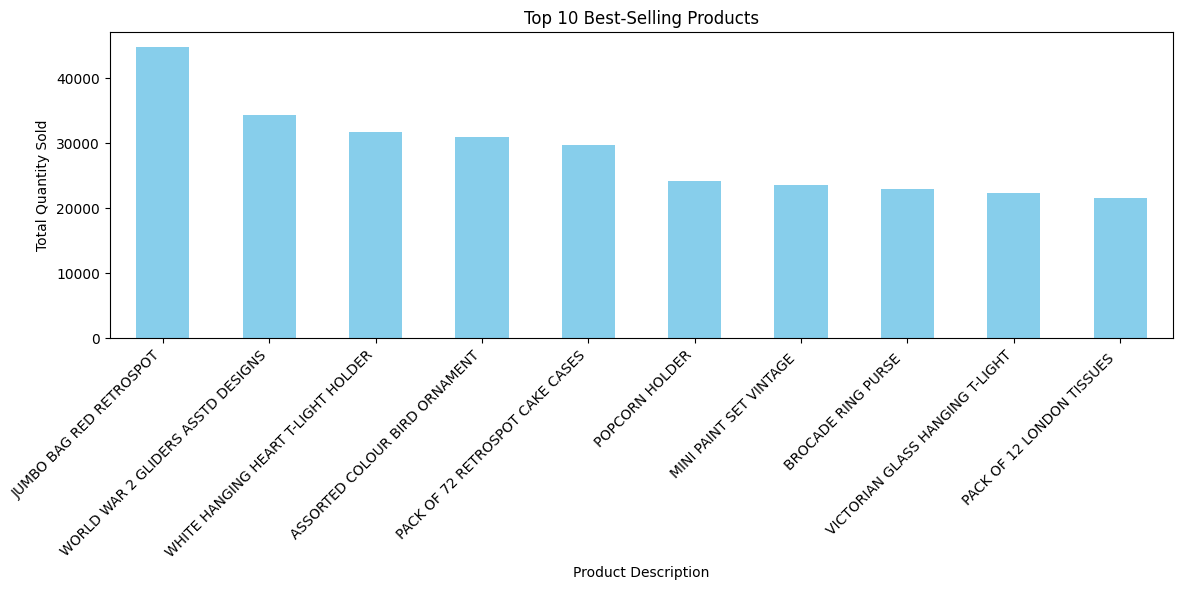

In [20]:
# Plotting Top 10 Best-Selling Products by Quantity

# Group by product description and sum the quantity sold, then sort and select top 10
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

# Plotting the bar chart
plt.figure(figsize=(12,6))
top_products.plot(kind='bar', color='skyblue')

# Adding title and labels
plt.title("Top 10 Best-Selling Products")
plt.xlabel("Product Description")
plt.ylabel("Total Quantity Sold")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### RFM Clusters using K-Means

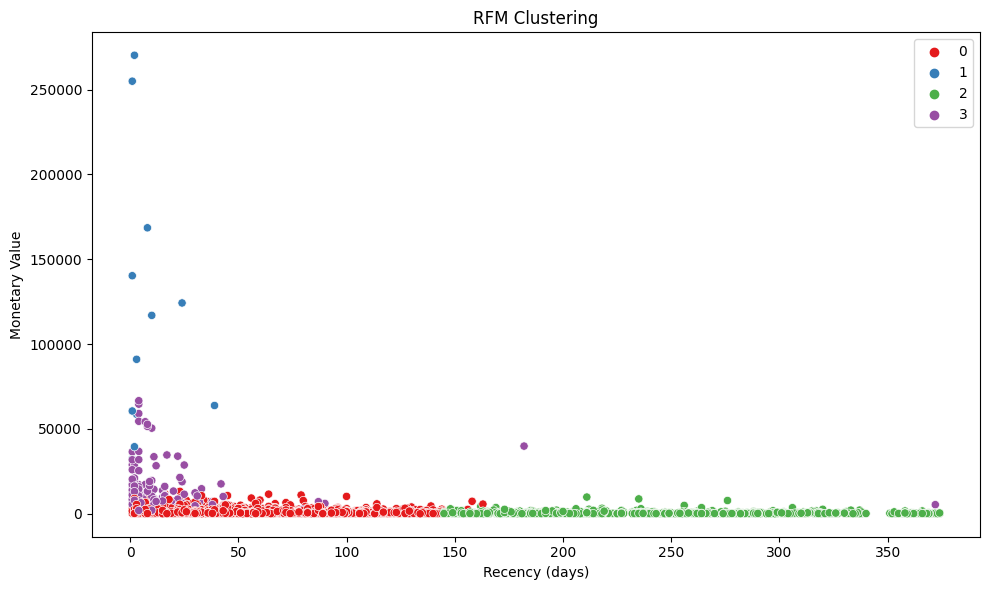

In [21]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import datetime

# RFM features
now = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (now - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                         # Frequency
    'TotalPrice': 'sum'                             # Monetary
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Normalize
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set1')
plt.title("RFM Clustering")
plt.xlabel("Recency (days)")
plt.ylabel("Monetary Value")
plt.legend()
plt.tight_layout()
plt.show()